In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
from transformers import BertTokenizer,pipeline, AutoModelForTokenClassification
from wordcloud import WordCloud
from textblob import TextBlob

con = sql.connect("C:/sql/databases/news_db.db")


tables = pd.read_sql("""SELECT * FROM news_articles;""",con)
print(tables)


       index                                              title  \
0          0  Ukraine: Angry Zelensky vows to punish Russian...   
1          1  War in Ukraine: Taking cover in a town under a...   
2          2         Ukraine war 'catastrophic for global food'   
3          3  Manchester Arena bombing: Saffie Roussos's par...   
4          4  Ukraine conflict: Oil price soars to highest l...   
...      ...                                                ...   
35855  35855  Bell leads England to ODI clean sweep over New...   
35856  35856  Murrays and all-British battles headline day four   
35857  35857  Highlights: Raducanu dominant in win over Mertens   
35858  35858  Chasing the 'Ghost' - a superstar struck down ...   
35859  35859           Le Pen's far-right at the gates of power   

                             pubDate  \
0      Mon, 07 Mar 2022 08:01:56 GMT   
1      Sun, 06 Mar 2022 22:49:58 GMT   
2      Mon, 07 Mar 2022 00:14:42 GMT   
3      Mon, 07 Mar 2022 00:05:40 GM

In [2]:
df = pd.read_sql("""SELECT pubDate,description,title FROM news_articles WHERE pubDate like '%JUN 2024%' ORDER BY pubDate DESC;""",con)

df.dtypes
df.isna().sum()

pubDate        0
description    0
title          0
dtype: int64

In [3]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)


In [4]:
df['title'].value_counts()

title
Election poll tracker: How do the parties compare?           22
Uefa Euro 2024 TV schedule                                    8
Who should I vote for and what are the parties promising?     6
How do the parties compare?                                   5
Continuing coverage of the campaign                           3
                                                             ..
Biden apologises for delay in Ukraine military aid            1
Body Shop sets deadline to save UK stores and jobs            1
CCTV appears to show Michael Mosley after leaving beach       1
Swinney condemns Sunak's early return from D-Day events       1
Six key takeaways from Starmer and Sunak's clash              1
Name: count, Length: 1336, dtype: int64

In [5]:
df['description'] = df['description'].str.lower()

def remove_html_tags(text):
    pattern = r'<.*>'
    text = re.sub(pattern,'',text)
    return text

df['description'] = df['description'].apply(remove_html_tags)

import string

def remove_punc(text):
    return text.translate(str.maketrans('','',string.punctuation))


df['description'] = df['description'].apply(remove_punc)


sw = set(stopwords.words("english"))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word.lower() not in sw]
    return " ".join(cleaned_tokens)


df['description'] = df['description'].apply(remove_stopwords)
df['description'].head(10)


0     troops pulled away government buildings hours ...
1     bbcs sarah smith looks whats stake men prove t...
2     space month 2012 andy murray went tears rain g...
3     combative exchanges last leaders debate ahead ...
7     rishi sunak keir starmer go headtohead final t...
8     ’ spin room sunak starmer go headtohead final ...
10    rhianon passmore investigated claims drove car...
11    gloves rishi sunak sir keir starmer went headt...
12    bbc sport takes look englands possible routes ...
15    conservative labour leaders taken audience que...
Name: description, dtype: object

In [6]:
lemma = WordNetLemmatizer()


def lemmatizer(text):
    tokens = word_tokenize(text)
    lemma_tokens = [lemma.lemmatize(text) for token in tokens]
    return " ".join(lemma_tokens)


df['description'] = df['description'].apply(lemmatizer)

In [7]:
text = " ".join(i for i in df['description'])



from nltk import FreqDist


blob = TextBlob(text).words

most_common_words = FreqDist(blob).most_common(50)
print("top 50 most common words\n",most_common_words)


top 50 most common words
 [('says', 1754), ('election', 1484), ('2024', 1426), ('bbc', 1287), ('euro', 1231), ('england', 1074), ('people', 922), ('say', 848), ('uk', 838), ('general', 782), ('first', 648), ('party', 610), ('labour', 578), ('’', 524), ('world', 518), ('vote', 503), ('new', 496), ('campaign', 492), ('one', 487), ('two', 457), ('leader', 456), ('win', 445), ('time', 417), ('us', 415), ('watch', 411), ('could', 402), ('open', 401), ('debate', 396), ('would', 396), ('final', 392), ('scotland', 369), ('cup', 367), ('t20', 361), ('police', 357), ('game', 351), ('said', 347), ('former', 345), ('group', 344), ('found', 334), ('manifesto', 326), ('president', 324), ('parties', 320), ('match', 319), ('gareth', 313), ('still', 307), ('poll', 304), ('european', 297), ('number', 293), ('made', 285), ('players', 283)]


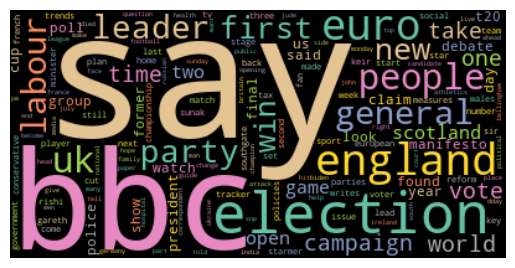

In [8]:
### wordcloud of most frequent words

wc = WordCloud(colormap="Set2",collocations=False).generate(text)
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show()



In [9]:
### this is for senitment analysis


blob = TextBlob(text).words



def polarity(text):
    return TextBlob(text).polarity


df['polarity'] = df['description'].apply(polarity)
print("polairty of description text\n",df['polarity'])

polairty of description text
 0       0.000000
1       0.100000
2       0.500000
3       0.025000
7       0.016667
          ...   
1568    0.350000
1569    0.000000
1570    0.000000
1571    0.000000
1572    0.000000
Name: polarity, Length: 1395, dtype: float64


In [10]:
# a sentiment is based on the polarity score.
# if sentiment = 0, this means word/pharse has no negative or positve sentiment
# if sentiment = 1, this means that the word/phrase has a postive sentiment

#ex

sample_sentiment_neutral = "how was your day?"
print(TextBlob(sample_sentiment_neutral).sentiment)

Sentiment(polarity=0.0, subjectivity=0.0)


In [11]:
## example of a negative sentiment

negative_sentiment_example = "WOW this traffic is so terrible I HATE THIS CAR!"
print(TextBlob(negative_sentiment_example).sentiment)
#the polarity is very negative, which is used to make the sentment discrete


Sentiment(polarity=-0.6333333333333333, subjectivity=0.9666666666666667)


In [12]:
#positive sentiment

positive_sentment = "lalala I love this day so much and sunshine makes me smile"
print("positive sentiment\n",TextBlob(positive_sentment).sentiment)


positive sentiment
 Sentiment(polarity=0.3333333333333333, subjectivity=0.3)


In [13]:
### polarity > 0 means the sentiment is postive
# if poliarity < 0; this means it is negative
# if polarity == 0; neurtal


def sentiment(label):
    if label <0:
        return "Negative"
    elif label == 0:
        return "Neutral"
    elif label > 0:
        return "Positive"


df['sentiment'] = df['polarity'].apply(sentiment)

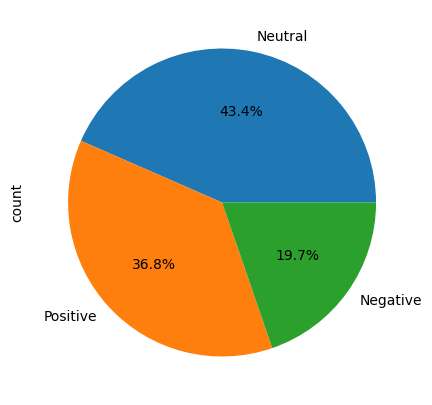

In [14]:
### a graph of the polarity of the text dataset


plt.figure(figsize=(10,5))
df['sentiment'].value_counts().plot(kind='pie',autopct="%1.1f%%")
plt.show()


In [15]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [16]:
### ok, first, time to check the sentiments of these articles



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

X = df['description']
y = df['sentiment']
y = le.fit_transform(y)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)


### since there are so many tokens, they will be limited
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000)

tokenizer.fit_on_texts(X_train)


### a word index to see the length needed for the word embedding

word_index = tokenizer.word_index
print("length of word index\n",len(word_index))


length of word index
 4559


In [17]:
### kind of long

### turning the text data into sequences

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


## ok, now to find the max length of the sequences for the input length of the word embedding

from tensorflow.keras.utils import pad_sequences,to_categorical

max_length = 0
for sequence in X_train:
    sequence_length = len(sequence)
    if sequence_length > max_length:
        max_length = sequence_length

print("Max Length of Sequences: ",max_length)

Max Length of Sequences:  484


In [18]:
### padding the text sequences to be ran through a LSTM

X_train = pad_sequences(X_train,padding="post")
X_test = pad_sequences(X_test,padding="post")

### turning the categorical data into numerical data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[123]
y_train[1]

###importing libraries to build LSTM model, Recurent Neural Networks for sentiment
### classifciaion

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,LSTM,Bidirectional,Dropout,SpatialDropout1D

### ok, this is how the LSTM RNN is set up
### Sequential data is data has spaces in between the features
# this does not mean it is some sort of "continous" variable
## Sequential data involves words, sound, prices, predicting stock prices
### this does mean the target variable is continous
### most of the time it is not
# in this example, the target variable is the sentiment
### as show in the graph above, it is categorical
### meaning, the reason labelencoder was used on y, was to turn
## the cateorical variables(target variable, for the Text data, they had to be tokenizer and
#turned into sequences) 
### The problem with RNNs has always been the "vanishing gradient problem"
### so, this Recurent neural network has layers:
# the emedding(input layer), hidding layers, output layers
### the output layers will predict the accuracy of the word embedding after
# if has been ran through all gradients in the RNN


LSTM_MODEL = Sequential()
LSTM_MODEL.add(Embedding(input_dim=(len(word_index)+1),output_dim=400,input_length=max_length))
LSTM_MODEL.add((SpatialDropout1D(0.3)))
LSTM_MODEL.add(Bidirectional(LSTM(250, dropout=0.1,recurrent_dropout=0.1)))
LSTM_MODEL.add((Dropout(0.2)))
LSTM_MODEL.add(Dense(units=180,activation='relu'))
LSTM_MODEL.add(Dropout(0.1))
LSTM_MODEL.add(Dense(units=3,activation='softmax'))
LSTM_MODEL.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])
history = LSTM_MODEL.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=0.2)
loss,acc = LSTM_MODEL.evaluate(X_test,y_test)
print("testing accuracy\n",acc)
print("testing loss\n",loss)


Epoch 1/10


C:\Users\katsa\anaconda3\envs\pytorch_env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.4245 - loss: 1.0673 - val_accuracy: 0.4955 - val_loss: 1.0006
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.6181 - loss: 0.8755 - val_accuracy: 0.6518 - val_loss: 0.8107
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.9536 - loss: 0.2337 - val_accuracy: 0.6875 - val_loss: 0.8620
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.9644 - loss: 0.1323 - val_accuracy: 0.5848 - val_loss: 2.7283
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.9946 - loss: 0.0397 - val_accuracy: 0.6339 - val_loss: 1.6503
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.9977 - loss: 0.0136 - val_accuracy: 0.6696 - val_loss: 1.3808
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.9972 - loss: 0.0121 - val_accuracy: 0.6384 - val_loss: 1.1275
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.6518 - val_loss: 1.30

In [19]:
### those were not very good
### you do not want your training accuracy to be much higher than your val accuracy
# this is not a good model, optimizing the weights take too long
## for the purpose of Game Theory and my PC, I am going to move on

### that is a problem with rnns and lots of text data
# something came out in 2017 that changed this problem and changed the world



### ok, this is the GAME
### two players will compete for postive and negative sentiments based on article reviews
## then I will find a Mixed Strategy NE from the game they actually played and then
### apply a better on in which the other player could have won

### player1 from tennis games


player1 = pd.read_sql("""
    SELECT * FROM news_articles 
    WHERE pubDate LIKE '%2024%' AND description LIKE '%Novak Djokovic%' 
    GROUP BY pubDate;
""", con)
print(player1)











    index                                              title  \
0   33093    Djokovic struck by water bottle at Italian Open   
1   28553  Djokovic loses at Australian Open for first ti...   
2   35568  Djokovic 'pain free' as he plays exhibition match   
3   34246   Djokovic injury fears after epic French Open win   
4   33180  Djokovic 'felt different' in shock loss after ...   
5   28502  Australian Open 2024: Novak Djokovic faces ste...   
6   34058  Djokovic moves through gears to earn another P...   
7   34305        Injured Djokovic withdraws from French Open   
8   30626         My level was really, really bad – Djokovic   
9   28091  Australian Open 2024: Alexei Popyrin believes ...   
10  33939  Djokovic 'moving in positive direction' with F...   

                          pubDate  \
0   Fri, 10 May 2024 21:36:18 GMT   
1   Fri, 26 Jan 2024 14:00:45 GMT   
2   Fri, 28 Jun 2024 20:53:17 GMT   
3   Mon, 03 Jun 2024 18:55:35 GMT   
4   Sun, 12 May 2024 19:01:12 GMT   
5   Thu, 

In [20]:
### player2 from tennis games

player2 = pd.read_sql("""
    SELECT * FROM news_articles 
    WHERE pubDate LIKE '%JUN 2024%' AND description LIKE '%Andy Murray%' 
    GROUP BY pubDate;
""", con)
print(player2)


   index                                              title  \
0  35374  Injured Murray 'not made decision' on Wimbledo...   
1  34921  Murray says retiring at Wimbledon or Olympics ...   
2  35044     Murray starts Queen's farewell with gritty win   
3  35125  Murray hopes back injury does not affect Wimbl...   
4  35431  The people v Andy Murray: Four weeks that chan...   

                         pubDate  \
0  Mon, 24 Jun 2024 08:10:14 GMT   
1  Sun, 16 Jun 2024 18:31:45 GMT   
2  Tue, 18 Jun 2024 20:12:39 GMT   
3  Wed, 19 Jun 2024 18:54:21 GMT   
4  Wed, 26 Jun 2024 23:02:17 GMT   

                                                guid  \
0  https://www.bbc.com/sport/tennis/articles/cj77...   
1  https://www.bbc.com/sport/tennis/articles/cd11...   
2  https://www.bbc.com/sport/tennis/articles/c844...   
3  https://www.bbc.com/sport/tennis/articles/crgg...   
4  https://www.bbc.com/sport/tennis/articles/c3g5...   

                                         description  
0  Andy Murr

In [21]:
player1_text = " ".join(i for i in player1['description'])
player2_text = " ".join(i for i in player2['description'])


### bert.


MODEL_NAME = 'bert-base-uncased'
## player1 tokens
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
player1_tokens = tokenizer.tokenize(player1_text)
player1_token_ids = tokenizer.convert_tokens_to_ids(player1_tokens)
print("tokens\n",player1_tokens)
print("token ids\n",player1_token_ids)

tokens
 ['novak', 'dj', '##oko', '##vic', 'is', 'hit', 'on', 'the', 'head', 'by', 'a', 'water', 'bottle', 'as', 'he', 'signs', 'auto', '##graphs', 'after', 'his', 'win', 'at', 'the', 'italian', 'open', '.', 'novak', 'dj', '##oko', '##vic', 'loses', 'at', 'the', 'australian', 'open', 'for', 'the', 'first', 'time', 'since', '2018', 'as', 'jan', '##nik', 'sinn', '##er', 'sets', 'up', 'a', 'final', 'against', 'dani', '##il', 'med', '##ved', '##ev', 'in', 'melbourne', '.', 'novak', 'dj', '##oko', '##vic', 'says', 'he', 'is', '"', 'pain', 'free', '"', 'after', 'coming', 'through', 'an', 'exhibition', 'against', 'dani', '##il', 'med', '##ved', '##ev', 'prior', 'to', 'the', 'start', 'of', 'wimbledon', 'next', 'week', '.', 'defending', 'champion', 'novak', 'dj', '##oko', '##vic', 'shows', 'his', 'supreme', 'powers', 'of', 'recovery', 'once', 'again', 'to', 'beat', 'francisco', 'ce', '##run', '##do', '##lo', 'and', 'reach', 'the', 'french', 'open', 'quarter', '-', 'finals', '.', 'novak', 'dj', '

In [22]:
pip install PIL

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


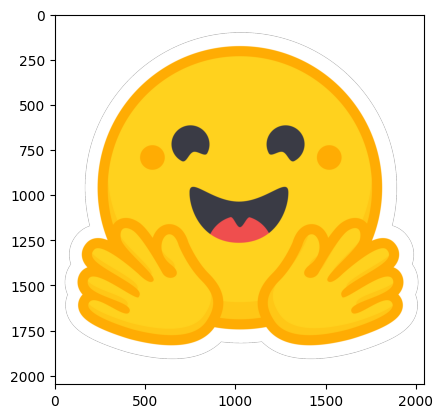

player 2 tokens
 ['andy', 'murray', 'has', 'not', 'made', 'a', 'decision', 'on', 'whether', 'he', 'will', 'be', 'fit', 'enough', 'to', 'make', 'a', 'planned', 'wimbledon', 'farewell', 'next', 'week', '.', 'andy', 'murray', 'says', 'he', 'would', 'prefer', 'to', 'retire', 'at', 'wimbledon', 'or', 'the', 'paris', 'olympics', 'as', 'his', 'tennis', 'career', 'draws', 'towards', 'an', 'end', '.', 'britain', "'", 's', 'andy', 'murray', 'begins', 'what', 'is', 'likely', 'to', 'be', 'his', 'final', 'queen', "'", 's', 'appearance', 'with', 'a', 'grit', '##ty', 'win', 'over', 'australia', "'", 's', 'alexei', 'pop', '##yr', '##in', '.', 'andy', 'murray', 'remains', 'hopeful', 'the', 'back', 'injury', 'which', 'ended', 'his', 'queen', "'", 's', 'campaign', 'will', 'not', 'deny', 'him', 'what', 'is', 'expected', 'to', 'be', 'a', 'final', 'appearance', 'at', 'wimbledon', '.', 'in', 'the', 'space', 'of', 'a', 'month', 'in', '2012', ',', 'andy', 'murray', 'went', 'from', 'tears', 'in', 'the', 'rain',

In [23]:

#player2 tokens
### WHO COULD FORGET TRANSFORMERS
import matplotlib.pyplot as plt
from PIL import Image
data_dir = "C:/Pictures/c3635b59-a3d2-444a-b636-a9d0061dcdde.png"

img = Image.open("C:/Pictures/c3635b59-a3d2-444a-b636-a9d0061dcdde.png")
plt.imshow(img)
plt.show()


tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
player2_tokens = tokenizer.tokenize(player2_text)
player2_token_ids = tokenizer.convert_tokens_to_ids(player2_tokens)
print("player 2 tokens\n",player2_tokens)
print("player 2 token_ids\n",player2_token_ids)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


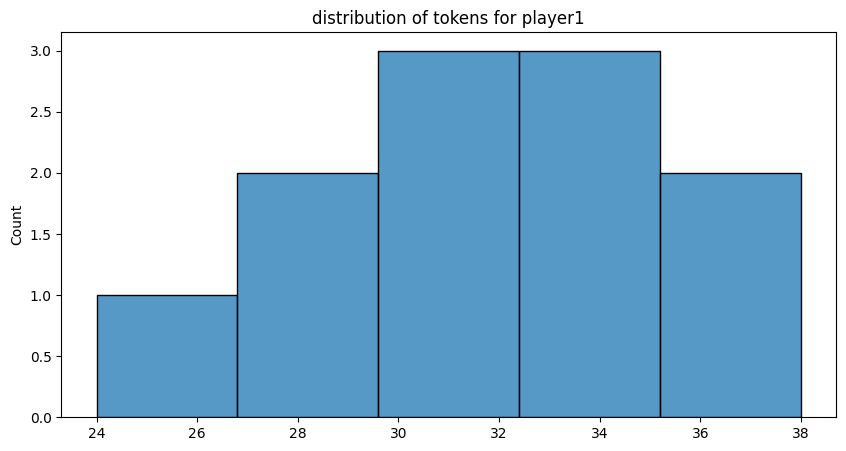

In [24]:
player1_tokens_l = []

for txt in player1['description']:
  tokens = tokenizer.encode(txt,max_length=512)
  player1_tokens_l.append(len(tokens))




plt.figure(figsize=(10,5))
sns.histplot(player1_tokens_l)
plt.title("distribution of tokens for player1")
plt.show()


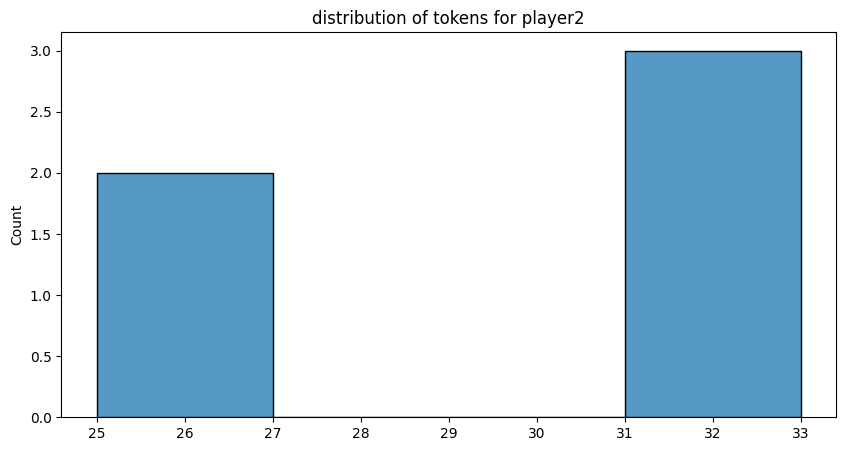

In [25]:
player2_tokens_l = []

for txt in player2['description']:
  tokens = tokenizer.encode(txt,max_length=512)
  player2_tokens_l.append(len(tokens))


plt.figure(figsize=(10,5))
sns.histplot(player2_tokens_l)
plt.title("distribution of tokens for player2")
plt.show()


In [26]:
NER_MODEL = "dslim/bert-base-NER"
model = AutoModelForTokenClassification.from_pretrained(NER_MODEL)
pipeline_name_entity = pipeline("ner", model=model, tokenizer=tokenizer)
player1_ner = pipeline_name_entity(player1_text)
print("name entity recognition results\n",player1_ner)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


name entity recognition results
 [{'entity': 'B-PER', 'score': np.float32(0.9650161), 'index': 9, 'word': 'head', 'start': None, 'end': None}, {'entity': 'B-ORG', 'score': np.float32(0.9285608), 'index': 11, 'word': 'a', 'start': None, 'end': None}, {'entity': 'I-ORG', 'score': np.float32(0.7013517), 'index': 12, 'word': 'water', 'start': None, 'end': None}, {'entity': 'B-ORG', 'score': np.float32(0.9822374), 'index': 16, 'word': 'signs', 'start': None, 'end': None}, {'entity': 'B-ORG', 'score': np.float32(0.9959714), 'index': 34, 'word': 'australian', 'start': None, 'end': None}, {'entity': 'B-ORG', 'score': np.float32(0.6698353), 'index': 43, 'word': 'jan', 'start': None, 'end': None}, {'entity': 'B-LOC', 'score': np.float32(0.9882173), 'index': 57, 'word': 'in', 'start': None, 'end': None}, {'entity': 'B-LOC', 'score': np.float32(0.9997042), 'index': 89, 'word': 'week', 'start': None, 'end': None}, {'entity': 'B-ORG', 'score': np.float32(0.9957902), 'index': 107, 'word': 'francisco'

In [27]:
### ok, a summary pipeline(not this is not cheating)
summarization_pipeline = pipeline("summarization", model="facebook/bart-large-cnn", framework="pt")
player1_summary = summarization_pipeline(player1_text[:1024])
print("summarization of player 1 in the articles\n",player1_summary)



player2_summary = summarization_pipeline(player2_text[:1024])
print("summary of player2 from articles\n",player2_summary)


Your max_length is set to 142, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


summarization of player 1 in the articles
 [{'summary_text': "Novak Djokovic was hit on the head by a water bottle at the Italian Open. The Serbian says he is 'pain free' ahead of the start of Wimbledon. Novak\xa0Djokovic faces Italian fourth seed Jannik Sinner in Friday's semi-final."}]
summary of player2 from articles
 [{'summary_text': "Andy Murray says he would prefer to retire at Wimbledon or the Paris Olympics as his tennis career draws towards an end. Britain's Andy Murray begins what is likely to be his final Queen's appearance with a gritty win over Australia's Alexei Popyrin. Murray has not made a decision on whether he will be fit enough to make a planned Wimbledon farewell next week."}]


In [29]:
pip install sympy

Note: you may need to restart the kernel to use updated packages.


In [34]:
#### The points of the tennis players in the two articles and there best p and q mix based on their point
import sympy as sym
p, q = sym.symbols('p, q')

A = sym.Matrix([[40/59,24/61], [64/120,5/32]])
B = sym.Matrix([[56/120, 37/61],[19/59,14/27]])
print("player1 payoffs\n",A)
print("player2 payoffs\n",B)


player1 payoffs
 Matrix([[0.677966101694915, 0.393442622950820], [0.533333333333333, 0.156250000000000]])
player2 payoffs
 Matrix([[0.466666666666667, 0.606557377049180], [0.322033898305085, 0.518518518518518]])


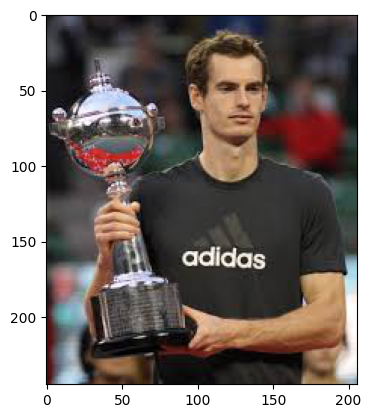

In [35]:
murray_image = Image.open("C:/Pictures/murray.jpg")
plt.imshow(murray_image)
### VSSSSSSSSS



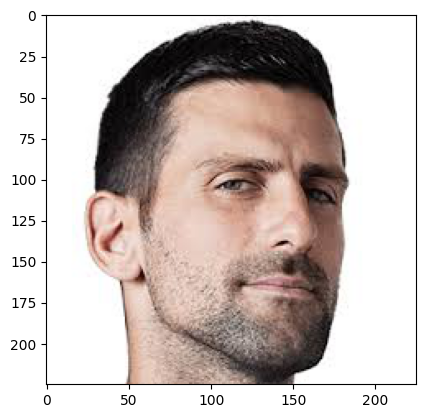

In [36]:
king_of_tennis = Image.open("C:/Pictures/king_of_GB.jpg")
plt.imshow(king_of_tennis)

In [54]:
## query for webscrapping of results
con = sql.connect("C:/sql/databases/news_db.db")
query2 = """
    SELECT guid FROM news_articles 
    WHERE description LIKE '%Novak Djokovic%' AND description LIKE '%Andy Murray%' 
    ORDER BY guid;
"""
pd.read_sql_query(query2,con)



####################################  

import requests
from bs4 import BeautifulSoup
import html

url = "https://www.techpolicy.press/the-consequences-of-big-techs-unchecked-consolidation-of-power/"
r = requests.get(url)
print("status code\n",r.status_code)

status code
 200


In [55]:
soup = BeautifulSoup(r.text,"html.parser")

results = soup.find('body')


results = [results.text for result in results]
results_txt = " ".join(results)

In [56]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens = tokenizer.tokenize(results_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("token_ids\n",token_ids)


token_ids
 [2188, 14399, 6558, 18155, 2594, 2100, 27080, 2638, 9333, 27901, 14536, 7716, 10526, 21572, 20614, 9363, 3372, 3089, 8569, 6591, 7875, 5833, 5280, 3686, 10760, 8465, 1997, 2502, 6627, 1005, 1055, 4895, 5403, 18141, 17439, 1997, 2373, 22327, 2063, 6519, 10052, 1013, 15476, 1020, 1010, 16798, 2549, 2386, 9756, 3119, 1010, 2028, 1997, 2048, 11342, 2580, 2011, 2745, 17595, 5753, 2005, 1996, 2976, 3119, 3222, 2311, 1999, 2899, 5887, 1012, 1999, 1037, 8637, 3247, 1010, 7483, 1037, 2976, 3648, 4161, 8224, 1037, 18847, 17699, 2102, 1010, 20077, 2008, 2009, 2109, 2049, 7444, 2597, 2000, 3482, 2041, 10159, 1998, 3715, 2049, 6475, 6304, 3020, 7597, 1012, 1996, 2194, 2097, 5574, 1996, 6996, 1010, 1998, 1996, 2553, 2097, 3497, 2202, 2086, 2936, 2000, 10663, 1012, 5564, 1010, 1996, 3291, 1997, 17439, 1997, 2373, 1999, 1996, 6627, 3068, 1516, 2926, 1999, 1996, 2398, 1997, 2074, 1037, 2261, 2867, 1010, 2164, 7513, 1010, 8224, 1010, 9733, 1010, 6207, 1010, 1998, 18804, 1516, 2097, 3613, 2046

In [57]:
summarization_pipeline = pipeline("summarization", model="facebook/bart-large-cnn", framework="pt")
summary_pipe = summarization_pipeline(results_txt[:1024])
print("summarization of player 1 in the articles\n",summary_pipe)



summarization of player 1 in the articles
 [{'summary_text': "The Consequences of Big Tech's Unchecked Consolidation of Power. The problem of consolidation of power in the tech industry will continue into the era of artificial intelligence, as these companies hoard infrastructure, resources, and talent. To understand why, consider the case of Microsoft and its relationship with OpenAI."}]


In [58]:
#ok the game is against this:
### incompent lazy people who can not learn basic programming
#### and the people who do, lets find nash equillibrium
### this aritcle cannot really blame these big tech companies



### first player


### ok, I am going to assign the payoffs accordling
### the lazy people have two plans of action and this game is simultaneuos
### the lazy peole can learn to program or just complain
# the people who can build RNNs and transformers have twho plans of actions
## keep doing the right thing(good) or they can stop(bad)
### the games payoffs are as follows
### Lazy people are L
### Data Lads as DL
### if the lazy people learn they get a payoff of 1 for trying
## if they complain, they get a payoff of 0
# if the data lads play Good, they get a payoff of 3(it is very rewarding)
### if the data lads stop,
## they get a payoff of (2), it is 2 because they still have the muscle memory from
#learning and not complaining
# if the data lads player good and the lazy people complain, payoff to data lads is 4
### and payoff to the lazy people is 0, because the data lads wead out the population
# of the incompetent in a data driven world
### if the data lads play good and the lazy people try, they get a payoff 1 for not complainng
# if the data lads play good while the lazy lads complain,
## they get a payoff of 3 becauase the lazy people might(very unlikely)
# take their spot
# if they data lads stop and the lazy lads compalin, the data lads get a payoff of
# 2 and the lazy lads get a payoff of 3 for being so annoying and enjoying
# knocking down the triumphant
# if they lazy lads try while the data lads stop, the lazy lads get a pay off 3 and the 
# data lads keep their same payoff if they were to play good and lazy lads were to try
# so the data lads would get the same payoff of 
# the payoffs to the lazy lads are 2 and the data lads have the same
### the games is as follows


import nashpy as nash
data_lads = np.array([[4,3],[2,4]])
lazy_people = np.array([[0,3],[3,3]])



game = nash.Game(data_lads,lazy_people)
game.payoff_matrices
print("payoffs\n",game.payoff_matrices)
### defining the nash equillibrium from nashpy
equilibria = game.support_enumeration()
print(equilibria)



payoffs
 (array([[4, 3],
       [2, 4]]), array([[0, 3],
       [3, 3]]))
<generator object support_enumeration at 0x000001FD06109B90>


In [59]:
for eq in equilibria:
    print(eq)

con.close()



(array([0., 1.]), array([0., 1.]))
